In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
%matplotlib inline

## Download Stock Data

In [2]:
import threading

date = '2015-06-15'
ticker_request_case_study = ['TDOC','WD','KNSL','BOMN','APPN']
ticker_request_yahoo_top30 = ['AAPL','MSFT','GOOG','AMZN','FB','TSLA','NVDA','DIS','NVO','AMD','ABNB','GM','NIO','F','RBLX','CRWD','DOCU','BIIB','NOK','AMC','GME','UPST','PSFE','TLRY','BB','PSTH','CLOV','BBBY','MVIS','SAML']
ticker_request_motley_fool_top30 = ['BTC','CMPS','CSTL','CURI','DCBO','GSHD','OM','UPST','CALT','DAVA','FLGT','FTHM','LMND','PUBM','SPT','TTCF','AVIR','BIGC','CELH','DOCN','FVRR','INMD','RETA','SMLR','YALA','AMWL','BTRS','DMTK','FROG','KOD','PGNY','POSH','SKLZ','RWM','VINP']
tickers = []
stocks = {}

def downloadStocks(ticker, date):
    try:
        stocks[ticker] = pdr.get_data_yahoo(ticker,date)
        stocks[ticker].drop('Adj Close', axis=1, inplace=True)
        stocks[ticker].drop('High', axis=1, inplace=True)
        stocks[ticker].drop('Low', axis=1, inplace=True)
        stocks[ticker].drop('Open', axis=1, inplace=True)
        stocks[ticker].drop('Volume', axis=1, inplace=True)
        tickers.append(ticker)
        print("Retrieved %s" % ticker)
    except:
        print("Failed to get %s" % ticker)

threads = []

for ticker in ticker_request_motley_fool_top30:
    ticker_thread = threading.Thread(target=downloadStocks, args=(ticker, date,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()

print(tickers)
stocks[tickers[0]].head()

Retrieved BTC
Retrieved PUBM
Retrieved SPT
Retrieved FLGT
Retrieved FROG
Retrieved FVRR
Retrieved BIGC
Retrieved POSH
Retrieved UPST
Retrieved CMPSRetrieved AVIR

Retrieved CSTL
Retrieved CALT
Retrieved DMTK
Retrieved FTHM
Retrieved BTRS
Retrieved DCBO
Retrieved LMNDRetrieved CURI

Retrieved TTCF
Retrieved DOCN
Retrieved YALARetrieved SKLZ

Retrieved DAVARetrieved VINP

Retrieved KOD
Retrieved OM
Retrieved INMD
Retrieved SMLR
Retrieved AMWL
Retrieved CELH
Retrieved GSHD
Retrieved RWM
Retrieved RETA
Retrieved PGNY
['BTC', 'PUBM', 'SPT', 'FLGT', 'FROG', 'FVRR', 'BIGC', 'POSH', 'UPST', 'CMPS', 'AVIR', 'CSTL', 'CALT', 'DMTK', 'FTHM', 'BTRS', 'DCBO', 'LMND', 'CURI', 'TTCF', 'DOCN', 'YALA', 'SKLZ', 'DAVA', 'VINP', 'KOD', 'OM', 'INMD', 'SMLR', 'AMWL', 'CELH', 'GSHD', 'RWM', 'RETA', 'PGNY']


Close
Date                 
2020-10-19  99.889999
2020-10-20  99.847000
2020-10-21  99.823997
2020-10-22  99.750000
2020-10-23  99.790001

## Generate Baseline Performance and Moving Average (MA) Performance

In [3]:
def generateSystems(ticker):
    stocks[ticker]['3-day'] = stocks[ticker]['Close'].rolling(3).mean()
    stocks[ticker]['9-day'] = stocks[ticker]['Close'].rolling(9).mean()
    stocks[ticker]['21-day'] = stocks[ticker]['Close'].rolling(21).mean()
    stocks[ticker]['Change'] = np.log(stocks[ticker].Close / stocks[ticker].Close.shift())
    
    # When the faster moving average is moving above the slower one, indicates time to buy
    stocks[ticker]['position-3-9'] = np.where(stocks[ticker]['3-day'] > stocks[ticker]['9-day'], 1,0)
    stocks[ticker]['position-9-21'] = np.where(stocks[ticker]['9-day'] > stocks[ticker]['21-day'], 1,0)
    # When the faster moving average is moving below the slower one, indicates time to sell
    stocks[ticker]['position-3-9'] = np.where(stocks[ticker]['3-day'] < stocks[ticker]['9-day'],-1,stocks[ticker]['position-3-9'])
    stocks[ticker]['position-9-21'] = np.where(stocks[ticker]['9-day'] < stocks[ticker]['21-day'],-1,stocks[ticker]['position-9-21'])
    
    # Whether we are making money with this system
    stocks[ticker]['system-3-9'] = np.where(stocks[ticker]['position-3-9'] > 0, stocks[ticker]['position-3-9']* stocks[ticker]['Change'],0)
    stocks[ticker]['system-9-21'] = np.where(stocks[ticker]['position-9-21'] > 0, stocks[ticker]['position-9-21']* stocks[ticker]['Change'],0)

    stocks[ticker]['Volatility'] = stocks[ticker].Change.rolling(21).std().shift()
    
threads = []

for ticker in tickers:
    ticker_thread = threading.Thread(target=generateSystems, args=(ticker,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()
    
stocks[tickers[0]].tail()

Close      3-day      9-day     21-day    Change  \
Date                                                               
2021-05-04  98.985001  98.939667  98.927112  99.252286  0.000404   
2021-05-05  99.059998  98.996666  98.933668  99.223477  0.000757   
2021-05-06  99.074997  99.039998  98.944222  99.180619  0.000151   
2021-05-07  99.148003  99.094332  98.964000  99.140096  0.000737   
2021-05-10  99.110001  99.111000  98.994778  99.102239 -0.000383   

            position-3-9  position-9-21  system-3-9  system-9-21  Volatility  
Date                                                                          
2021-05-04             1             -1    0.000404          0.0    0.001812  
2021-05-05             1             -1    0.000757          0.0    0.001818  
2021-05-06             1             -1    0.000151          0.0    0.001834  
2021-05-07             1             -1    0.000737          0.0    0.001666  
2021-05-10             1             -1   -0.000383          0.0    0.001680

## Generate DGIM MA Performance

In [4]:
%reload_ext autoreload
%autoreload 2
from ipynb.fs.full.DGIMMovingAverage import *
import threading

bit_depth = 16
num_buckets = 5

def generateDGIMSystems(ticker):
    stocks_list = stocks[ticker]['Close'].tolist()
    stocks_3day_list = stocks[ticker]['3-day'].tolist()
    stocks_9day_list = stocks[ticker]['9-day'].tolist()
    stocks_21day_list = stocks[ticker]['21-day'].tolist()
    stocks_list_bin = [ np.array(list(np.binary_repr(round(elem)).zfill(bit_depth))).astype(np.int8) for elem in stocks_list ]

    try:
        dgim_3day = DGIMMovingAverage(stocks_list_bin, 3, num_buckets, bit_depth, stocks_3day_list, True)
        stocks[ticker]['3-day-dgim'] = dgim_3day.mov_avg
        dgim_9day = DGIMMovingAverage(stocks_list_bin, 9, num_buckets, bit_depth, stocks_9day_list, True)
        stocks[ticker]['9-day-dgim'] = dgim_9day.mov_avg
        dgim_21day = DGIMMovingAverage(stocks_list_bin, 21, num_buckets, bit_depth, stocks_21day_list, True)
        stocks[ticker]['21-day-dgim'] = dgim_21day.mov_avg

        # When the faster moving average is moving above the slower one, indicates time to buy
        stocks[ticker]['position-dgim-3-9'] = np.where(stocks[ticker]['3-day-dgim'] > stocks[ticker]['9-day-dgim'], 1,0)
        stocks[ticker]['position-dgim-9-21'] = np.where(stocks[ticker]['9-day-dgim'] > stocks[ticker]['21-day-dgim'], 1,0)

        # When the faster moving average is moving below the slower one, indicates time to sell\
        stocks[ticker]['position-dgim-3-9'] = np.where(stocks[ticker]['3-day-dgim'] < stocks[ticker]['9-day-dgim'],-1,stocks[ticker]['position-dgim-3-9'])
        stocks[ticker]['position-dgim-9-21'] = np.where(stocks[ticker]['9-day-dgim'] < stocks[ticker]['21-day-dgim'],-1,stocks[ticker]['position-dgim-9-21'])

        # Whether we are making money with this system
        stocks[ticker]['system-dgim-3-9'] = np.where(stocks[ticker]['position-dgim-3-9'] > 0, stocks[ticker]['position-dgim-3-9']* stocks[ticker]['Change'],0)
        stocks[ticker]['system-dgim-9-21'] = np.where(stocks[ticker]['position-dgim-9-21'] > 0, stocks[ticker]['position-dgim-9-21']* stocks[ticker]['Change'],0)
        
        print("Finished %s" % ticker)
    except Exception as e:
        print("Failed to analyze %s" % ticker, e)
        tickers.remove(ticker)

threads = []

for ticker in tickers:
    ticker_thread = threading.Thread(target=generateDGIMSystems, args=(ticker,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()

Finished BTC
Finished POSH
Finished DOCN
Finished PUBM
Finished UPST
Finished VINP
Finished DCBO
Finished AVIR
Finished FROG
Finished CMPS
Finished OMFinished BTRS

Finished YALA
Finished BIGC
Finished FTHM
Finished AMWL
Finished CALT
Finished LMND
Finished SPT
Finished SKLZFinished CURI

Finished TTCF
Finished PGNY
Finished CSTL
Finished INMD
Finished FVRR
Finished KOD
Finished DAVA
Finished GSHD
Finished DMTK
Finished FLGT
Finished RETA
Finished CELH
Finished SMLR
Finished RWM


## Generate Normalized DGIM MA Performance

In [5]:
def normalizeDGIM(ticker):
    try:
        stocks[ticker]['3-day-dgim-norm']=(stocks[ticker]['3-day-dgim']-stocks[ticker]['3-day-dgim'].mean())/stocks[ticker]['3-day-dgim'].std()
        stocks[ticker]['9-day-dgim-norm']=(stocks[ticker]['9-day-dgim']-stocks[ticker]['9-day-dgim'].mean())/stocks[ticker]['9-day-dgim'].std()
        stocks[ticker]['21-day-dgim-norm']=(stocks[ticker]['21-day-dgim']-stocks[ticker]['21-day-dgim'].mean())/stocks[ticker]['21-day-dgim'].std()

        # When the faster moving average is moving above the slower one, indicates time to buy
        stocks[ticker]['position-dgim-3-9-norm'] = np.where(stocks[ticker]['3-day-dgim-norm'] > stocks[ticker]['9-day-dgim-norm'], 1,0)
        stocks[ticker]['position-dgim-9-21-norm'] = np.where(stocks[ticker]['9-day-dgim-norm'] > stocks[ticker]['21-day-dgim-norm'], 1,0)
        # When the faster moving average is moving below the slower one, indicates time to sell
        stocks[ticker]['position-dgim-3-9-norm'] = np.where(stocks[ticker]['3-day-dgim-norm'] < stocks[ticker]['9-day-dgim-norm'],-1,stocks[ticker]['position-dgim-3-9-norm'])
        stocks[ticker]['position-dgim-9-21-norm'] = np.where(stocks[ticker]['9-day-dgim-norm'] < stocks[ticker]['21-day-dgim-norm'],-1,stocks[ticker]['position-dgim-9-21-norm'])

        # Whether we are making money with this system
        stocks[ticker]['system-dgim-3-9-norm'] = np.where(stocks[ticker]['position-dgim-3-9-norm'] > 0, stocks[ticker]['position-dgim-3-9-norm']* stocks[ticker]['Change'],0)
        stocks[ticker]['system-dgim-9-21-norm'] = np.where(stocks[ticker]['position-dgim-9-21-norm'] > 0, stocks[ticker]['position-dgim-9-21-norm']* stocks[ticker]['Change'],0)
    except:
        pass

threads = []

for ticker in tickers:
    ticker_thread = threading.Thread(target=normalizeDGIM, args=(ticker,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()
    
stocks[tickers[0]].tail()

Close      3-day      9-day     21-day    Change  \
Date                                                               
2021-05-04  98.985001  98.939667  98.927112  99.252286  0.000404   
2021-05-05  99.059998  98.996666  98.933668  99.223477  0.000757   
2021-05-06  99.074997  99.039998  98.944222  99.180619  0.000151   
2021-05-07  99.148003  99.094332  98.964000  99.140096  0.000737   
2021-05-10  99.110001  99.111000  98.994778  99.102239 -0.000383   

            position-3-9  position-9-21  system-3-9  system-9-21  Volatility  \
Date                                                                           
2021-05-04             1             -1    0.000404          0.0    0.001812   
2021-05-05             1             -1    0.000757          0.0    0.001818   
2021-05-06             1             -1    0.000151          0.0    0.001834   
2021-05-07             1             -1    0.000737          0.0    0.001666   
2021-05-10             1             -1   -0.000383          0.0    0.001680   

            ...  position-dgim-9-21  system-dgim-3-9  system-dgim-9-21  \
Date        ...                                                          
2021-05-04  ...                  -1              0.0               0.0   
2021-05-05  ...                  -1              0.0               0.0   
2021-05-06  ...                  -1              0.0               0.0   
2021-05-07  ...                  -1              0.0               0.0   
2021-05-10  ...                  -1              0.0               0.0   

            3-day-dgim-norm  9-day-dgim-norm  21-day-dgim-norm  \
Date                                                             
2021-05-04        -0.902201        -1.077691         -0.351510   
2021-05-05        -0.902201        -1.077691         -1.070508   
2021-05-06        -0.902201        -1.077691         -1.310175   
2021-05-07        -0.902201        -1.077691         -1.549841   
2021-05-10        -0.902201        -1.077691         -1.789507   

            position-dgim-3-9-norm  position-dgim-9-21-norm  \
Date                                                          
2021-05-04                       1                       -1   
2021-05-05                       1                       -1   
2021-05-06                       1                        1   
2021-05-07                       1                        1   
2021-05-10                       1                        1   

            system-dgim-3-9-norm  system-dgim-9-21-norm  
Date                                                     
2021-05-04              0.000404               0.000000  
2021-05-05              0.000757               0.000000  
2021-05-06              0.000151               0.000151  
2021-05-07              0.000737               0.000737  
2021-05-10             -0.000383              -0.000383  

[5 rows x 24 columns]

## View Individual Stocks DGIM/Normalized DGIM MA vs. Baseline and MA Performance

/usr/local/Cellar/jupyterlab/3.0.16/libexec/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/Cellar/jupyterlab/3.0.16/libexec/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/Cellar/jupyterlab/3.0.16/libexec/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 fi

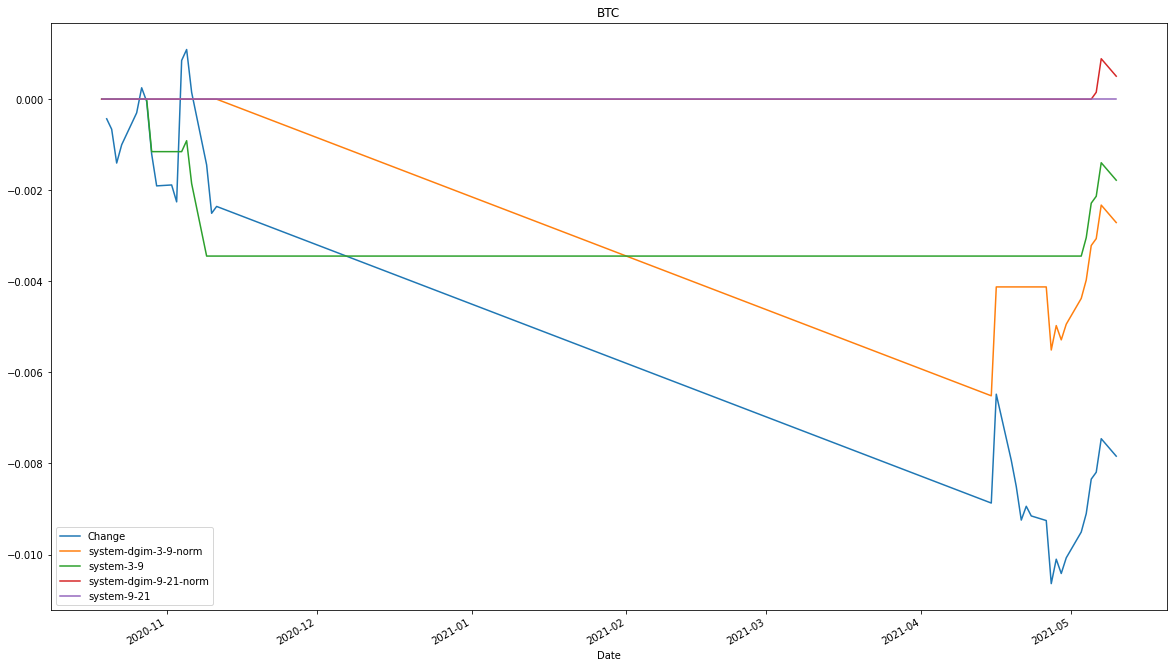

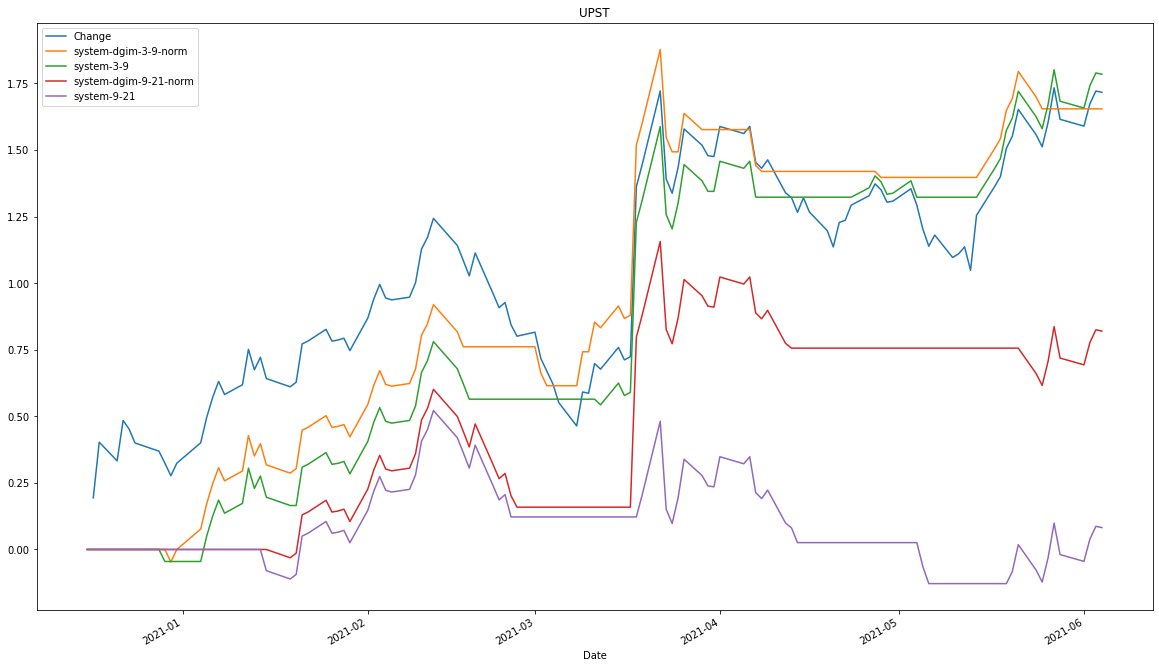

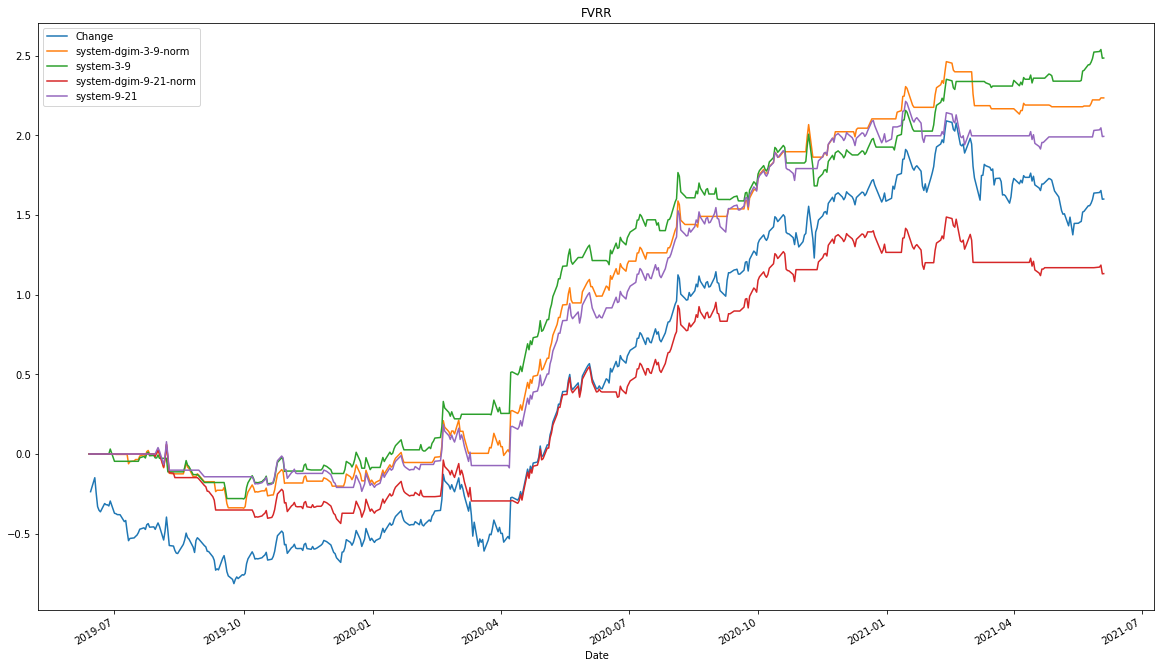

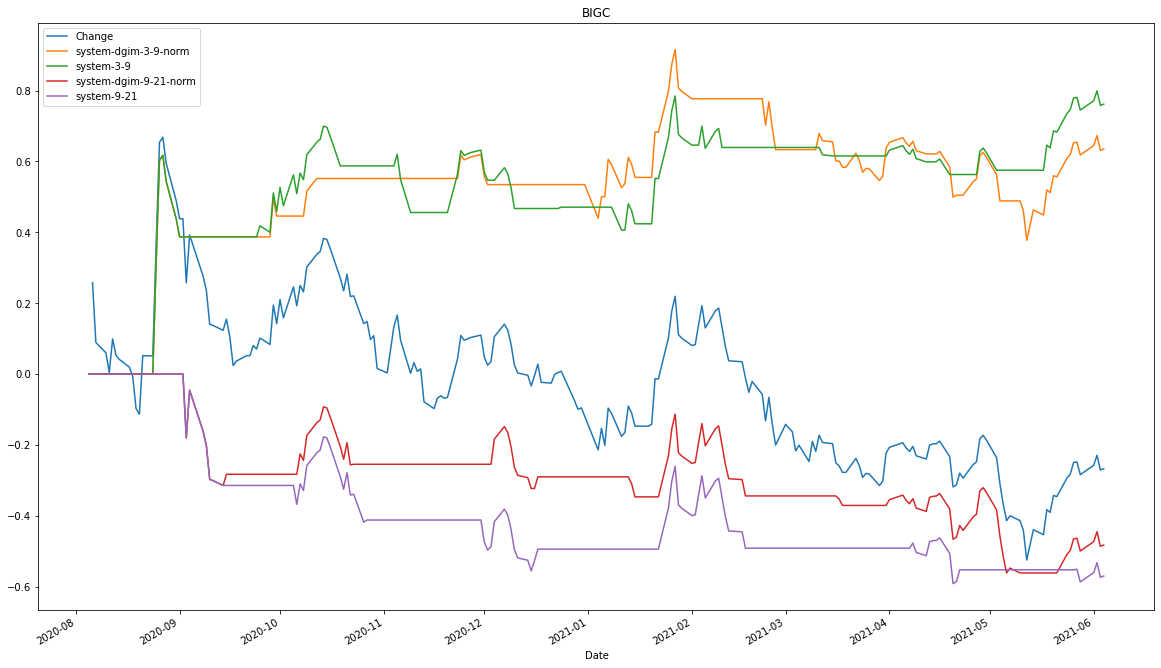

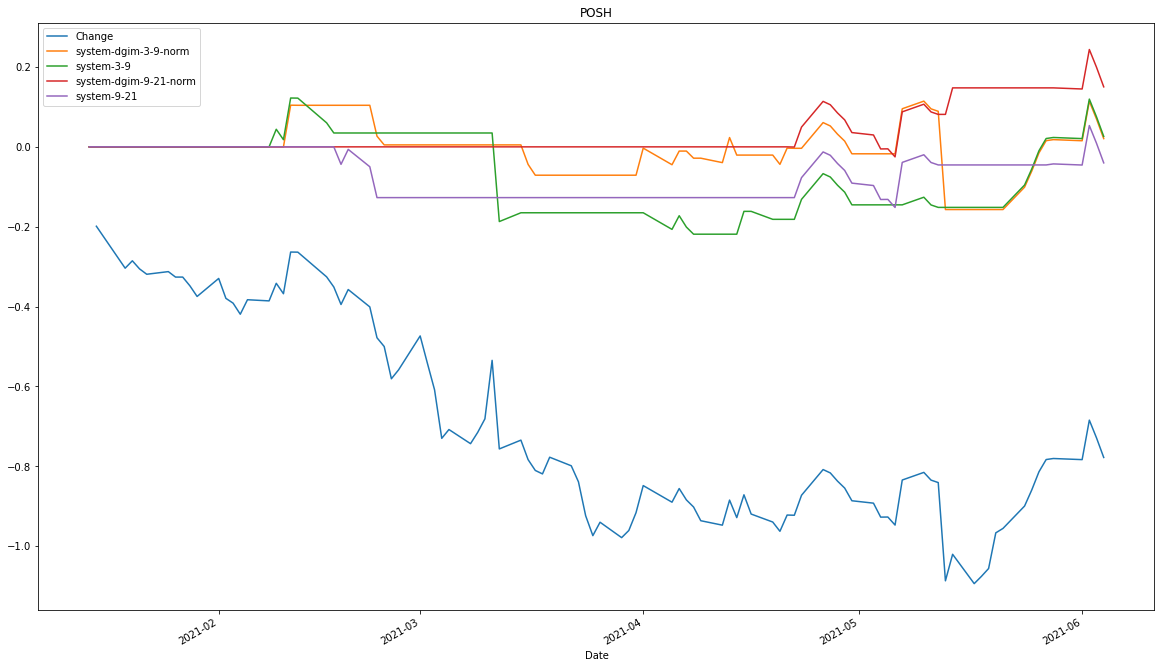

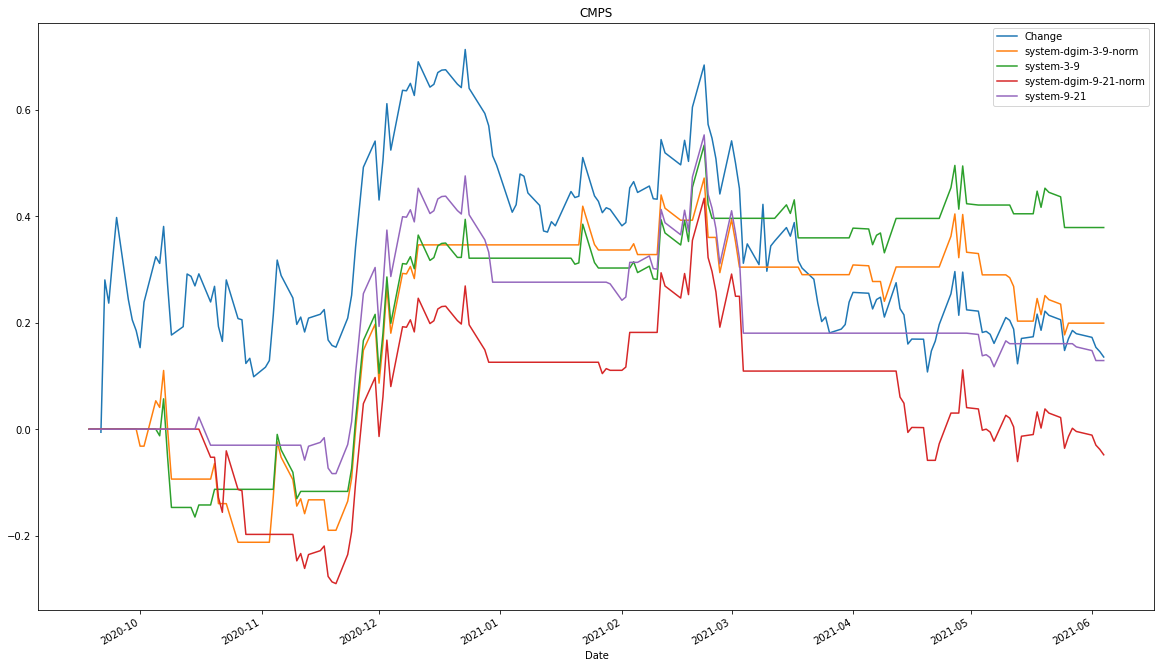

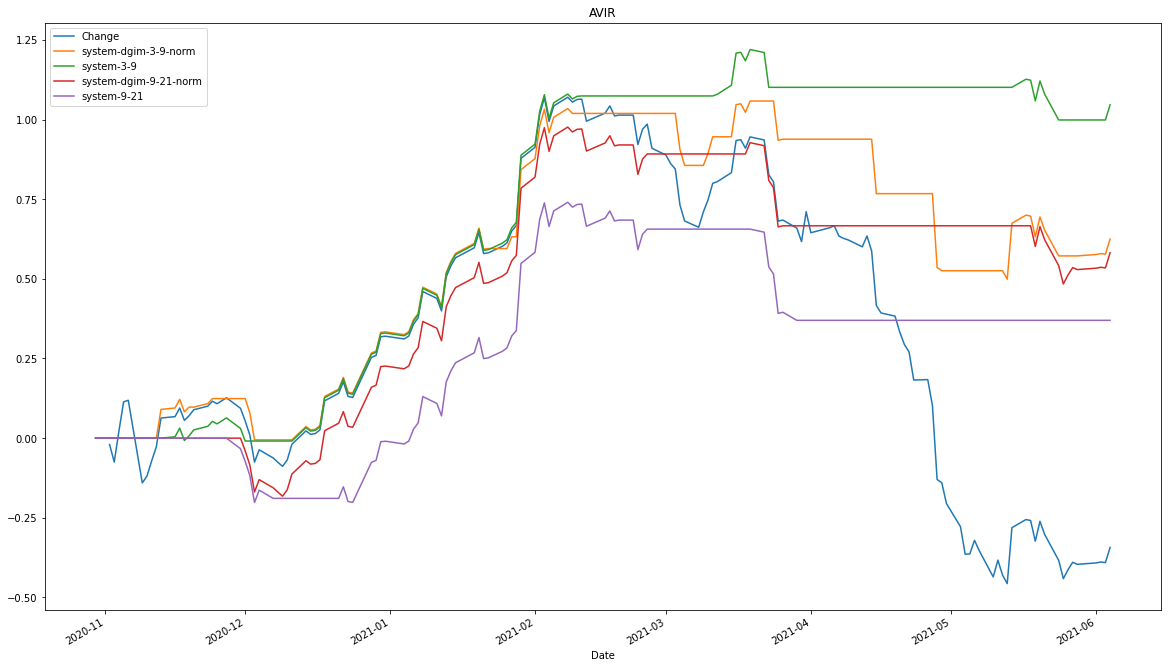

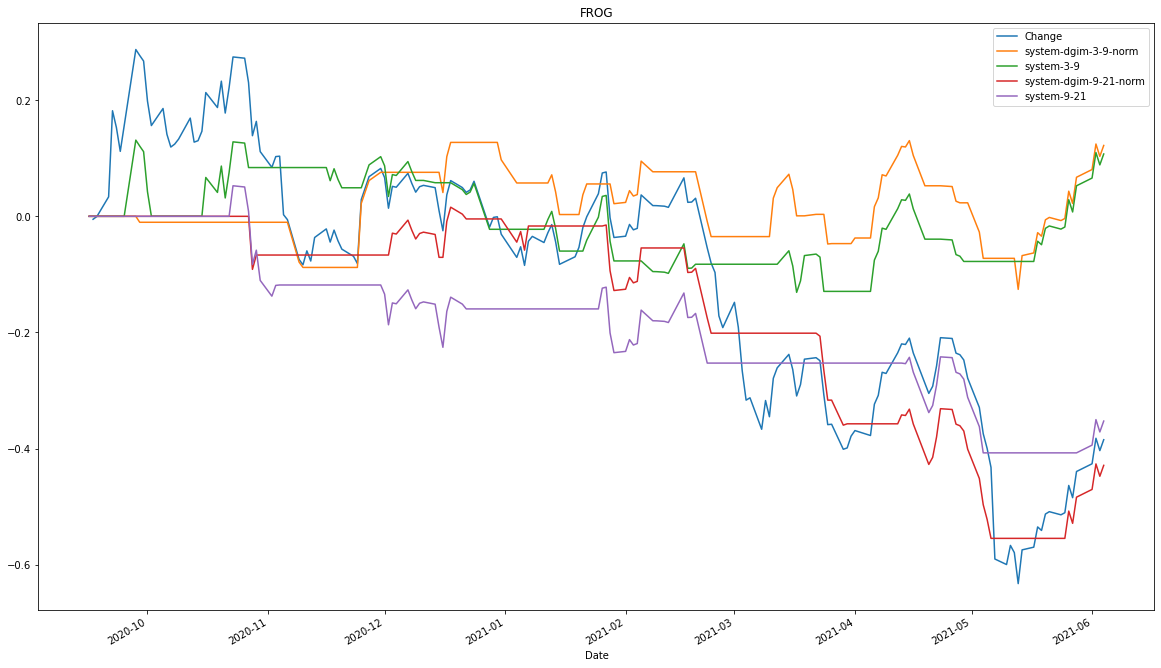

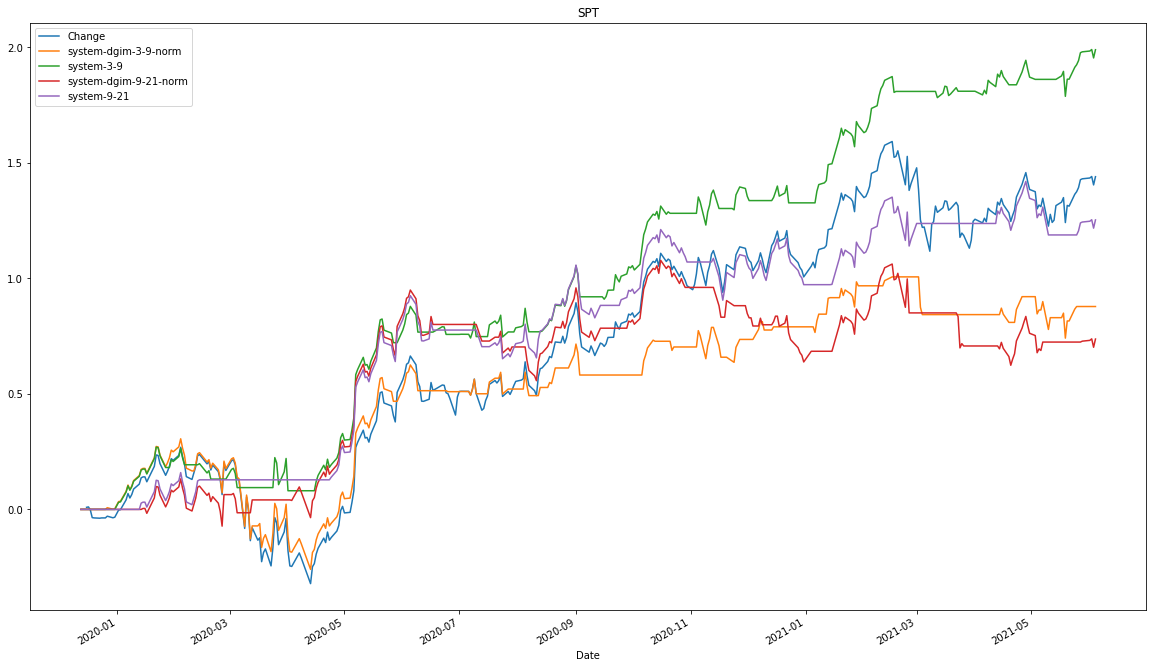

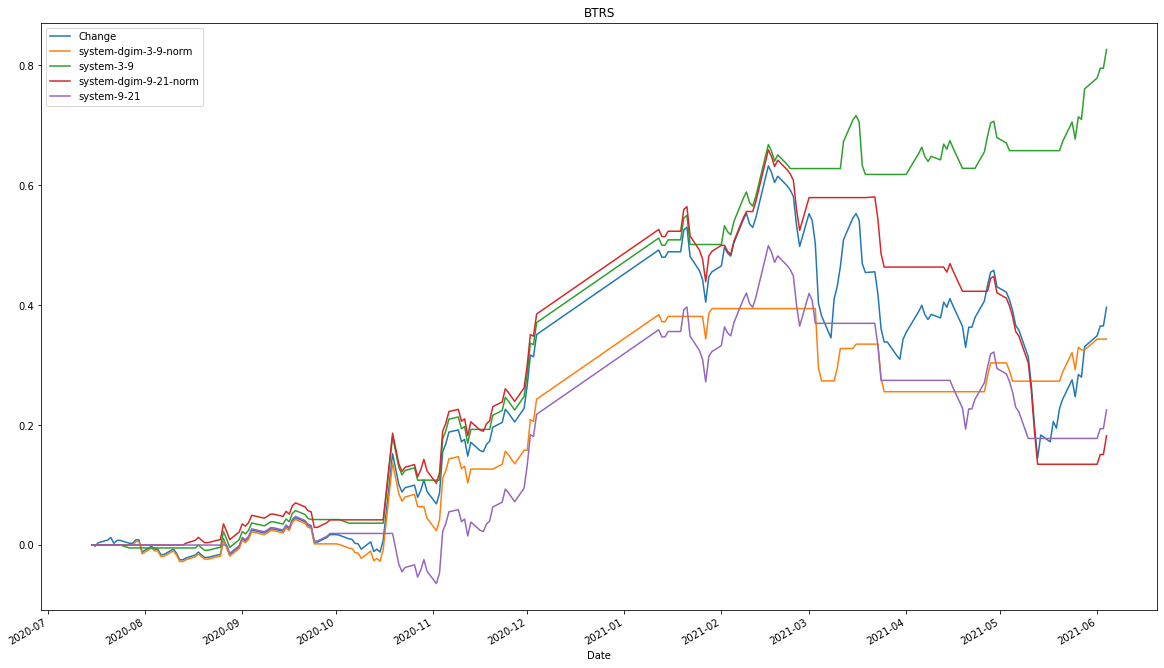

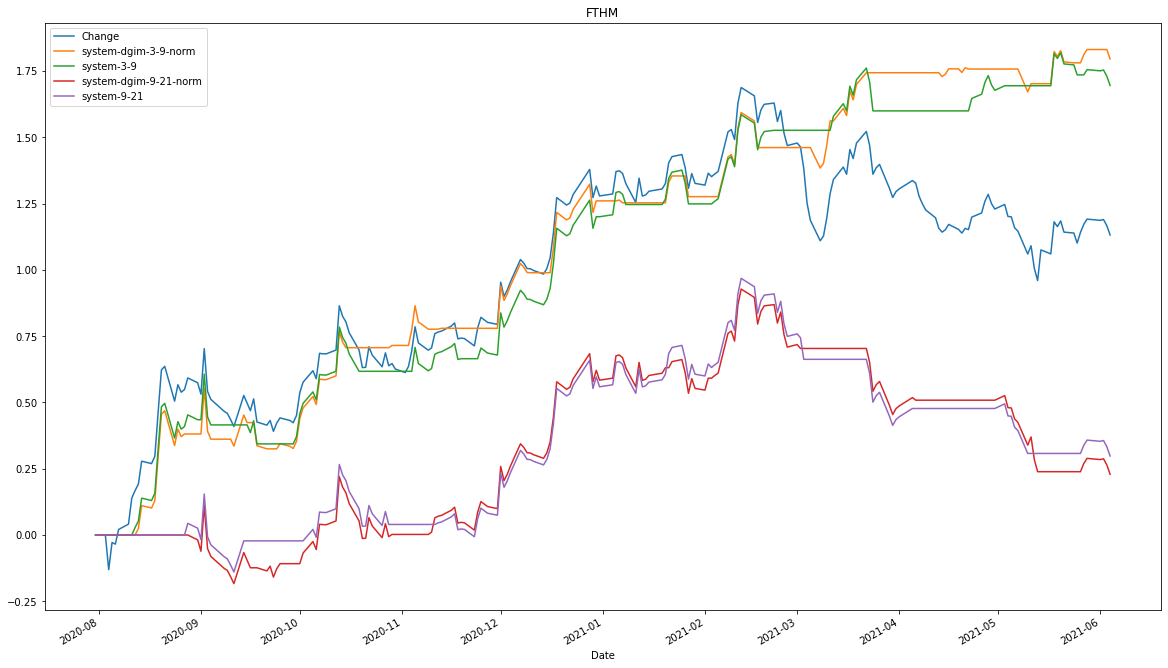

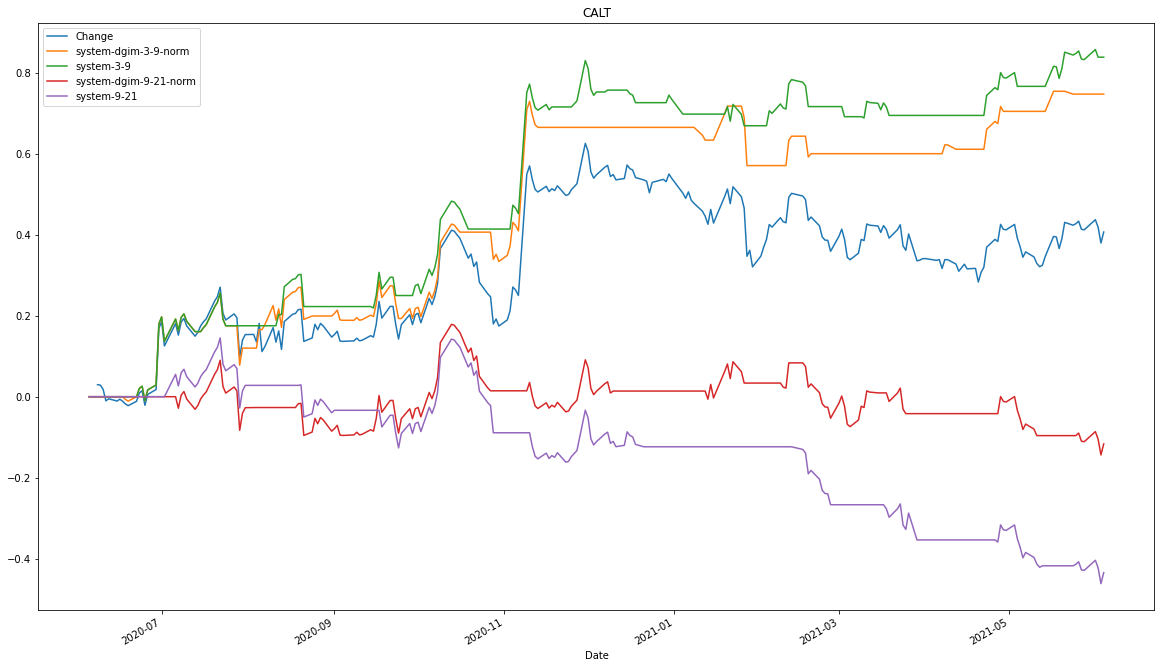

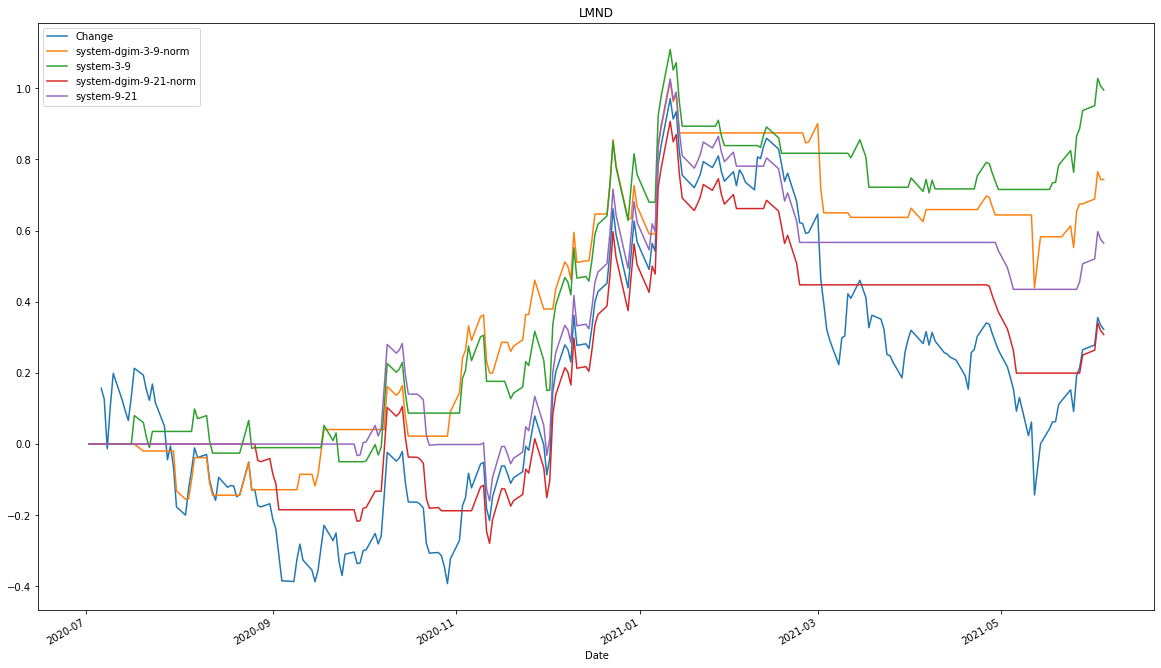

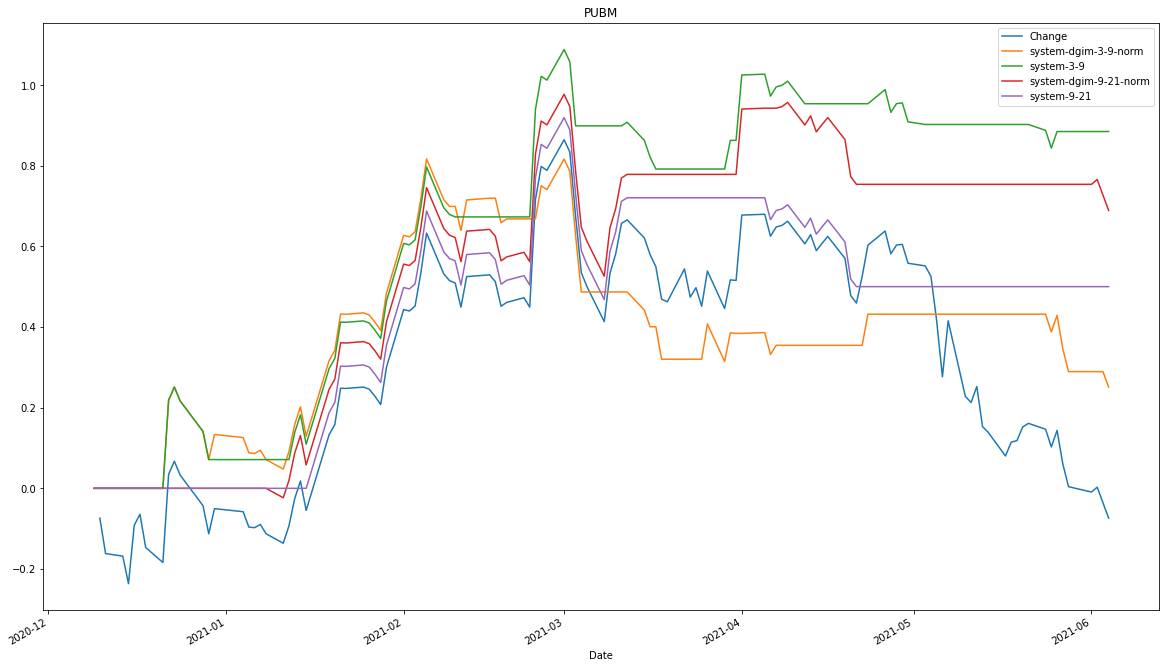

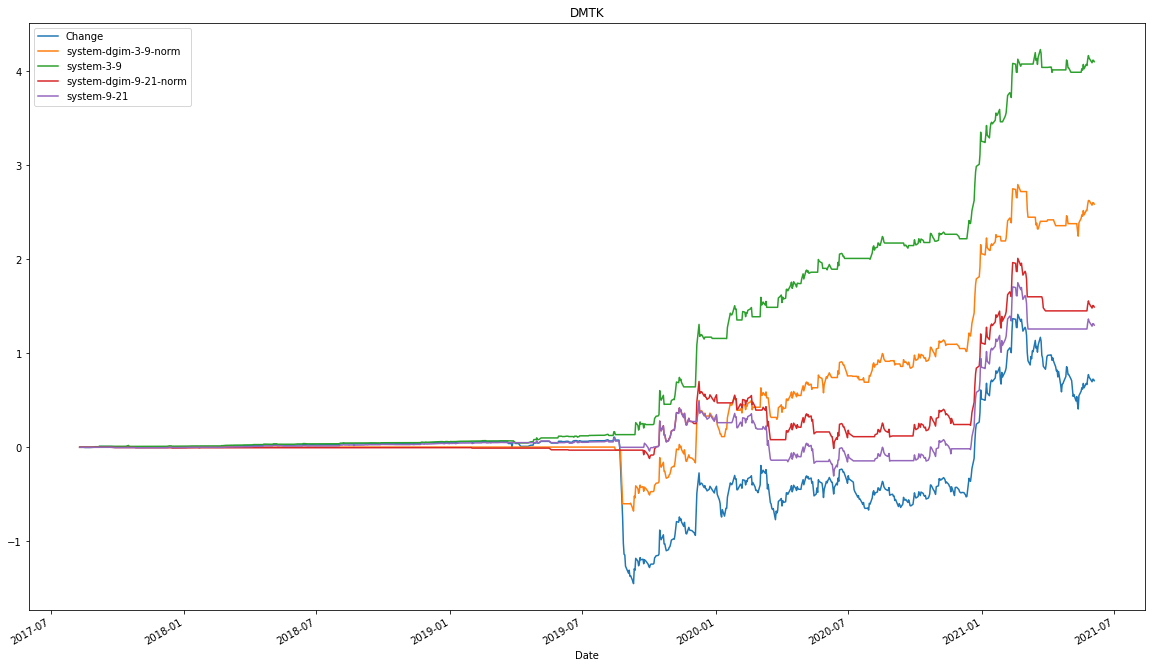

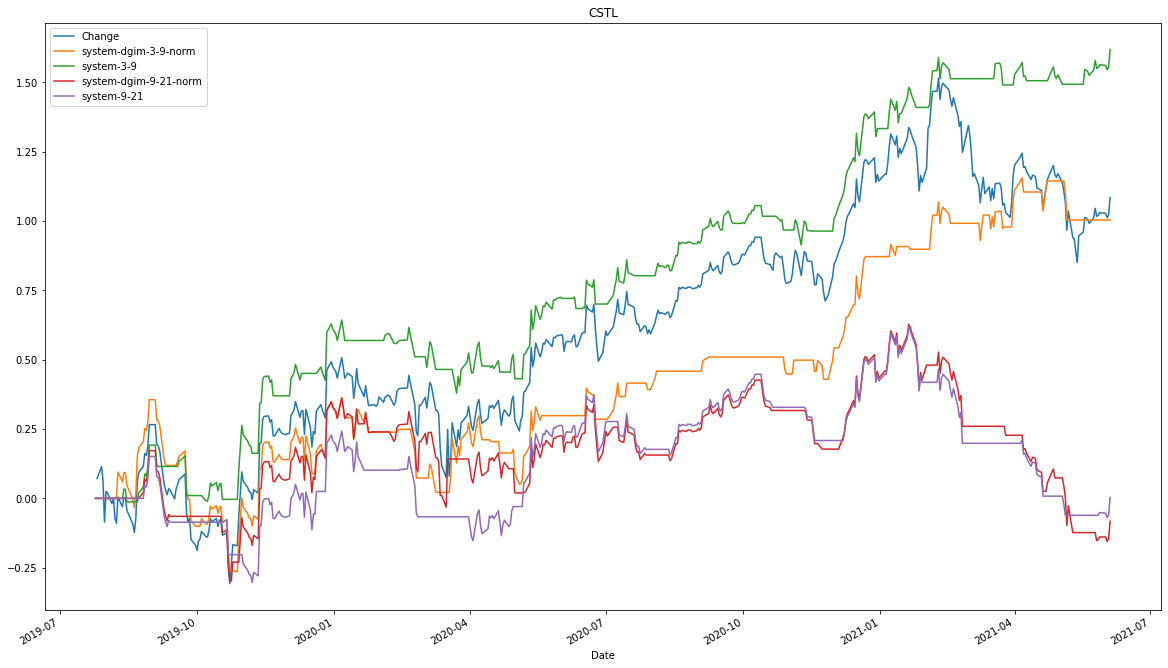

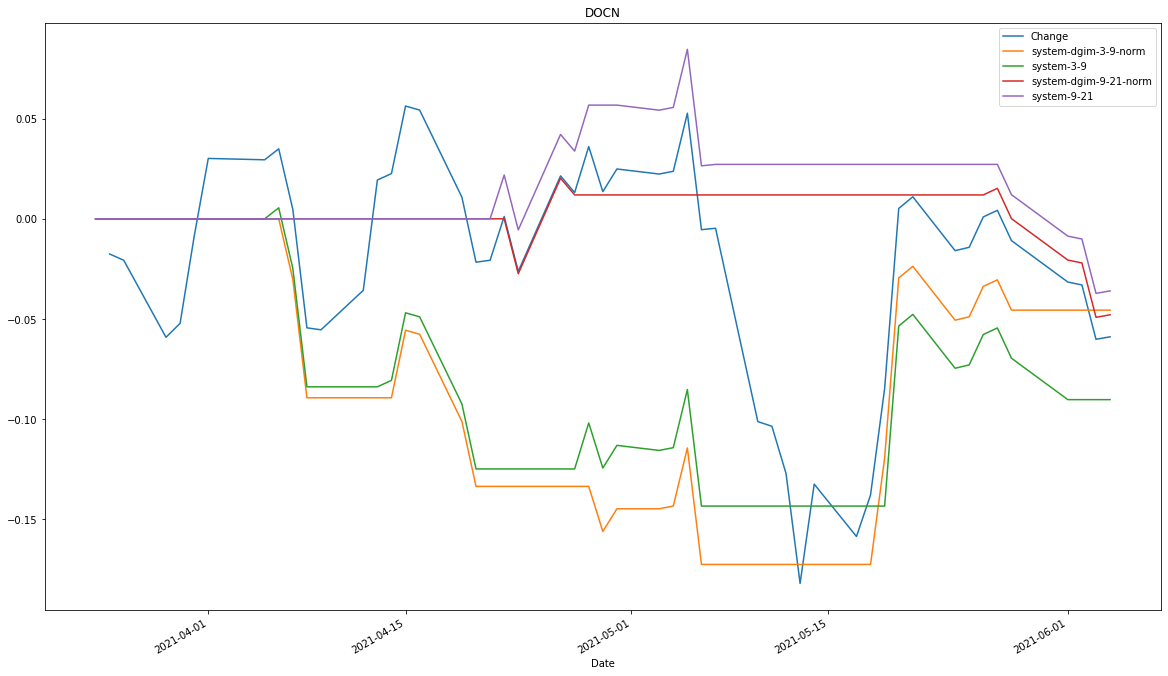

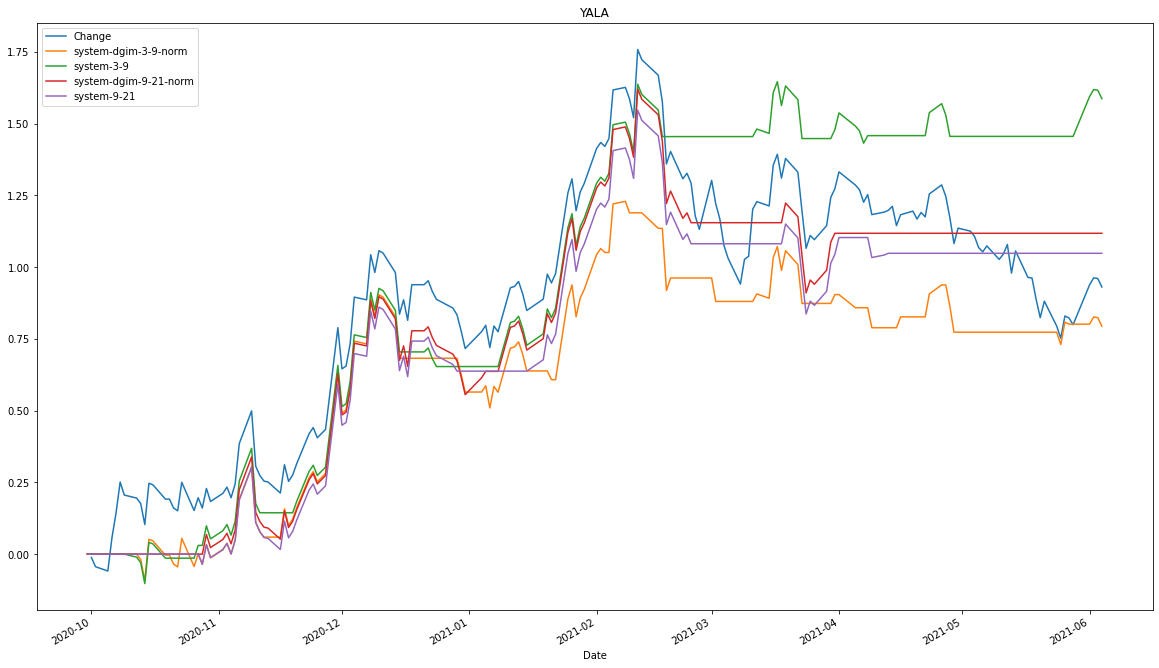

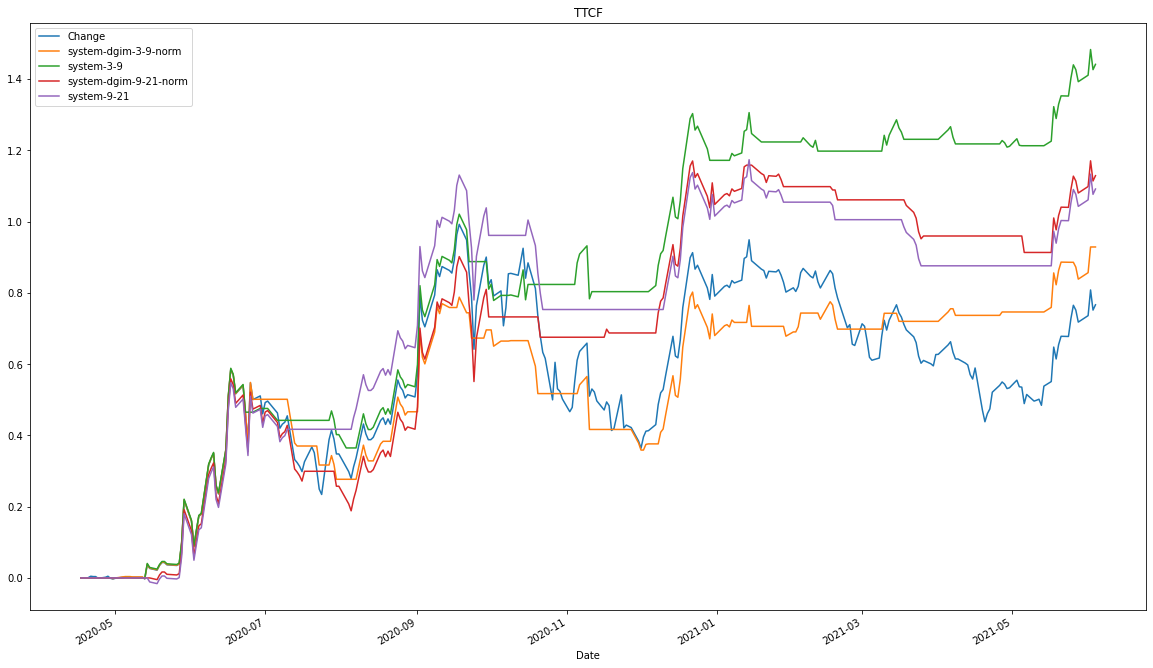

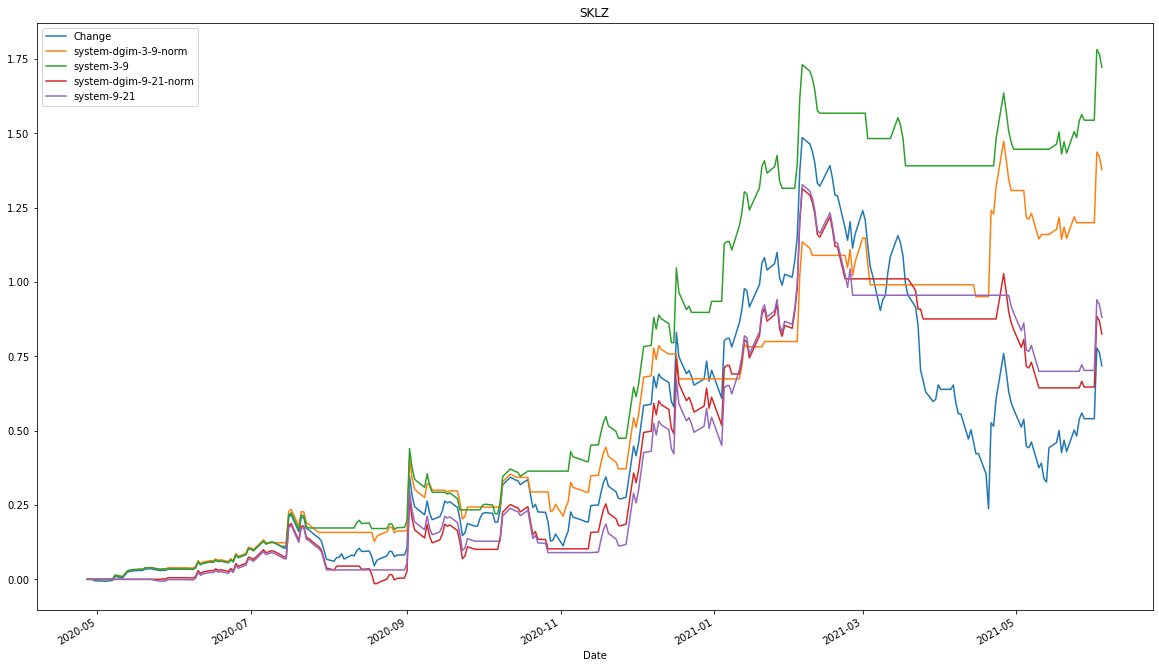

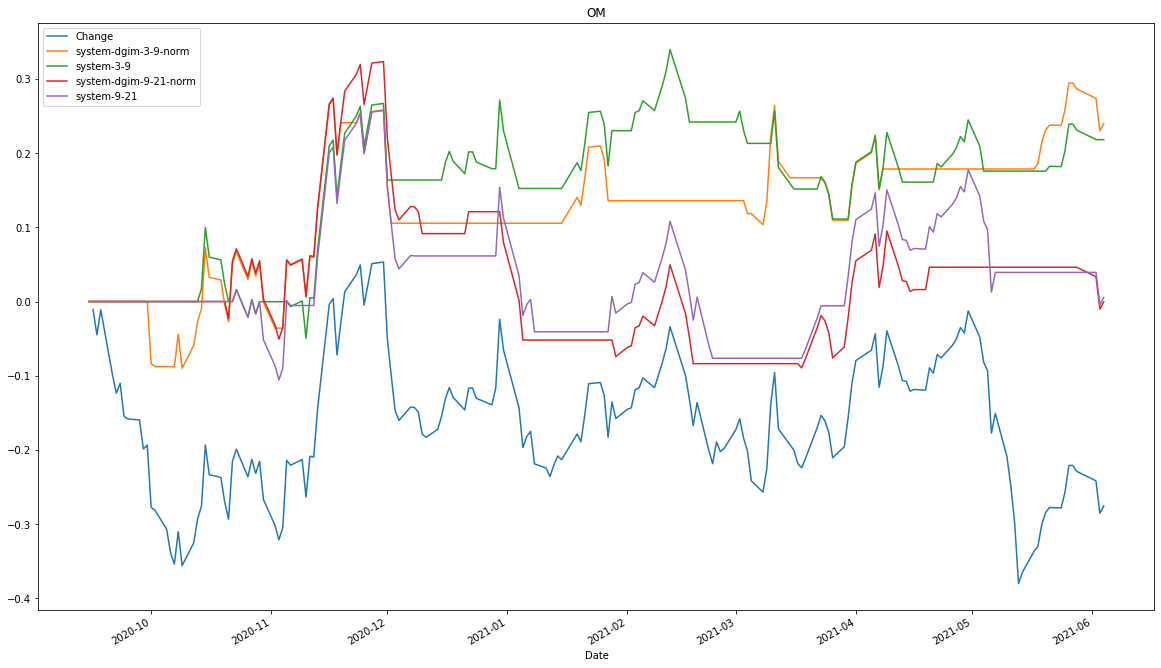

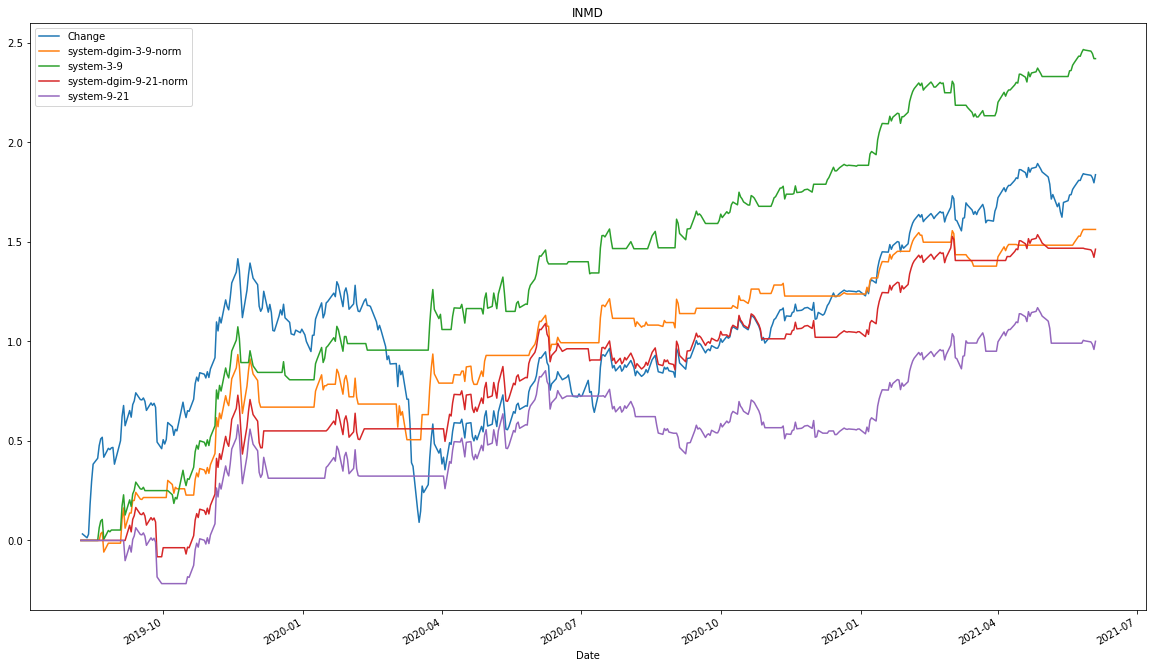

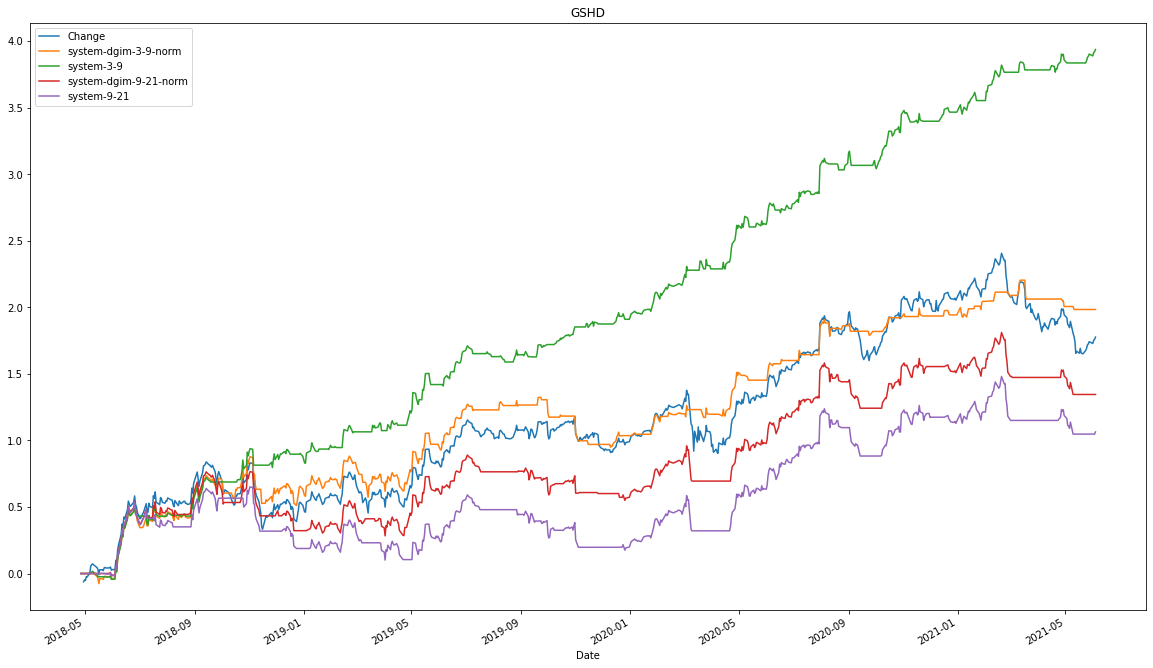

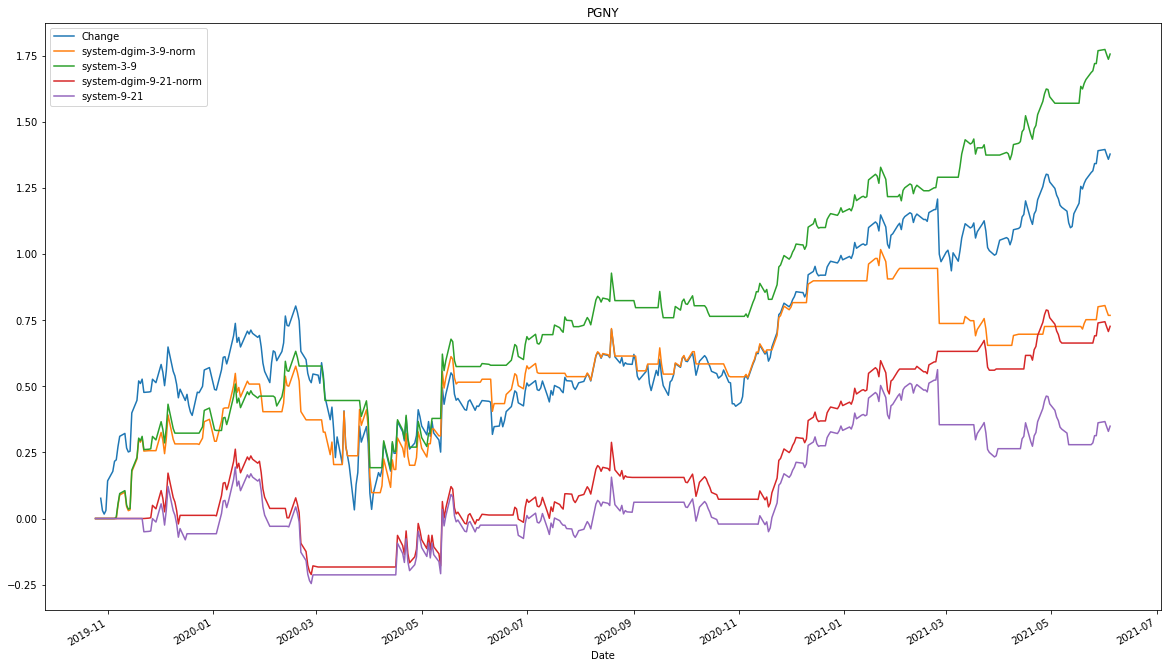

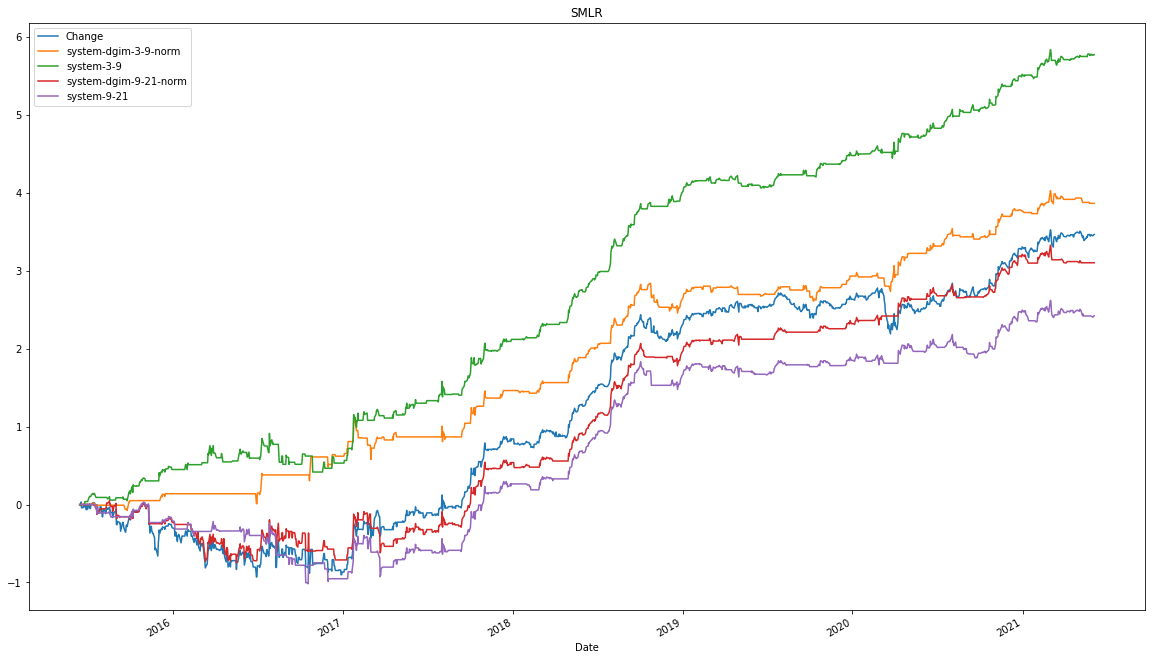

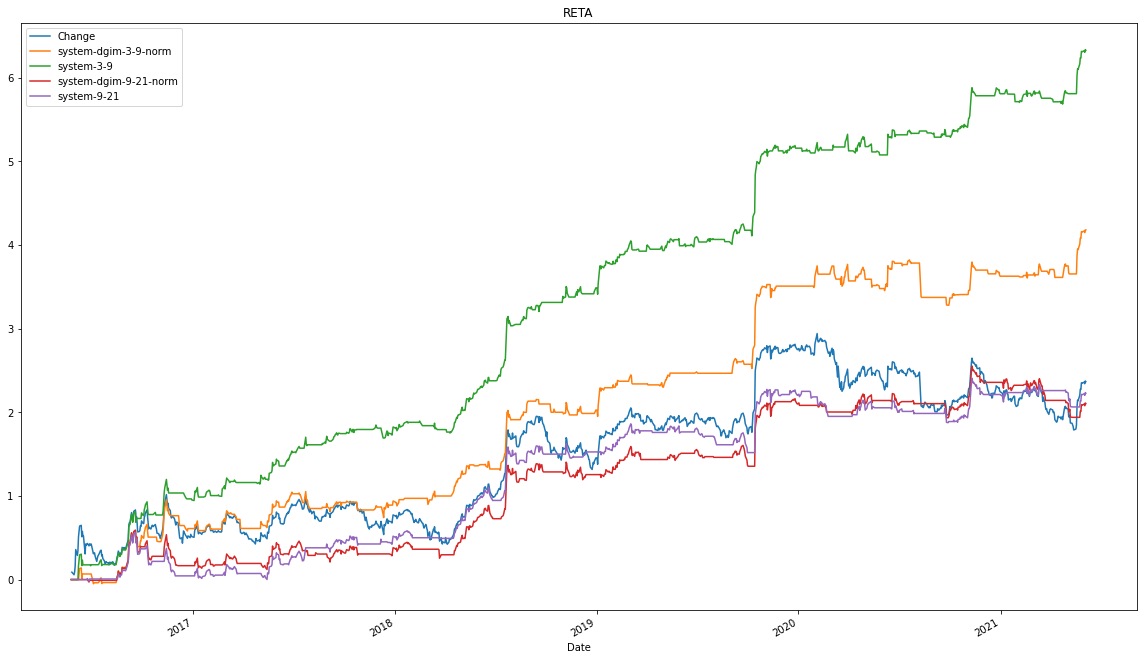

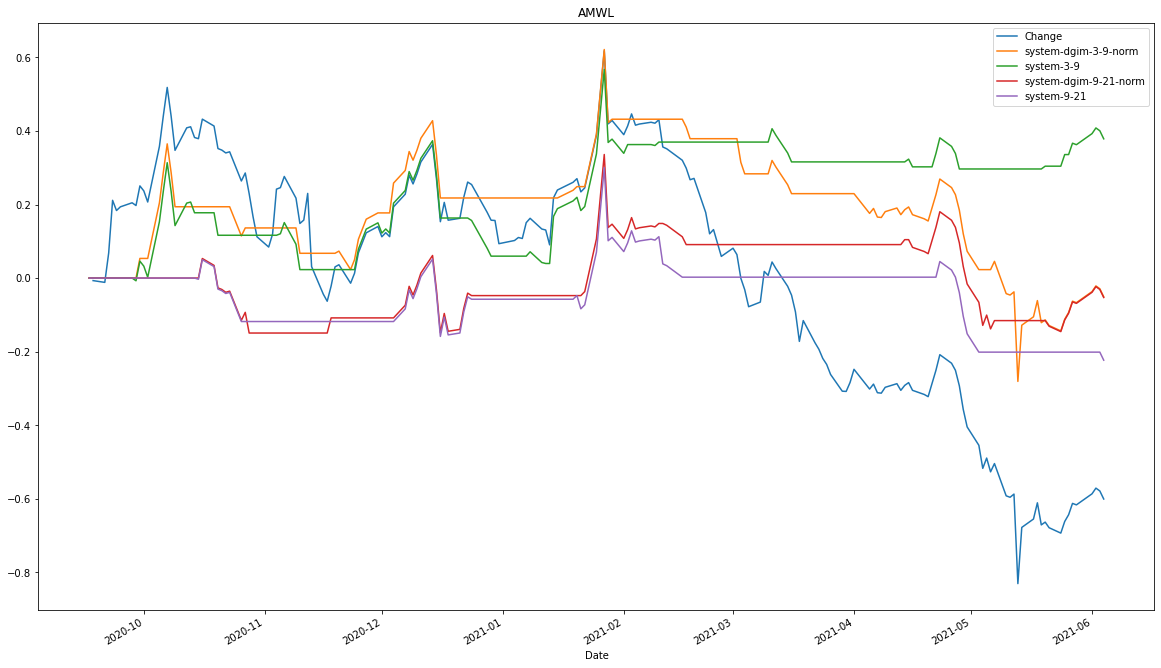

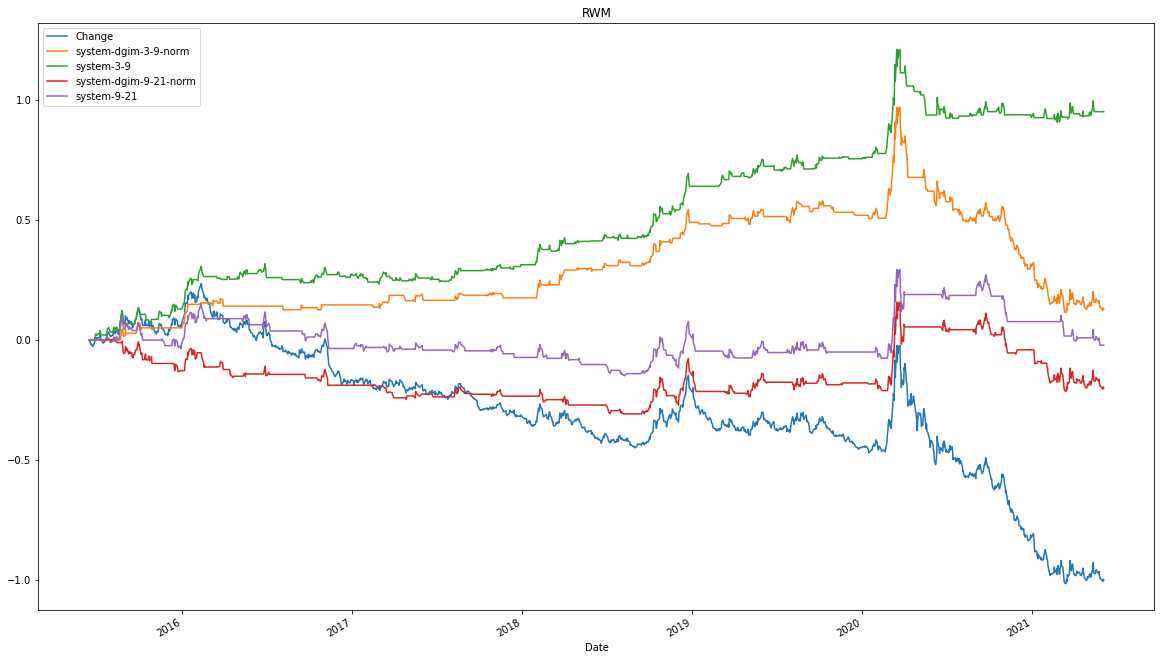

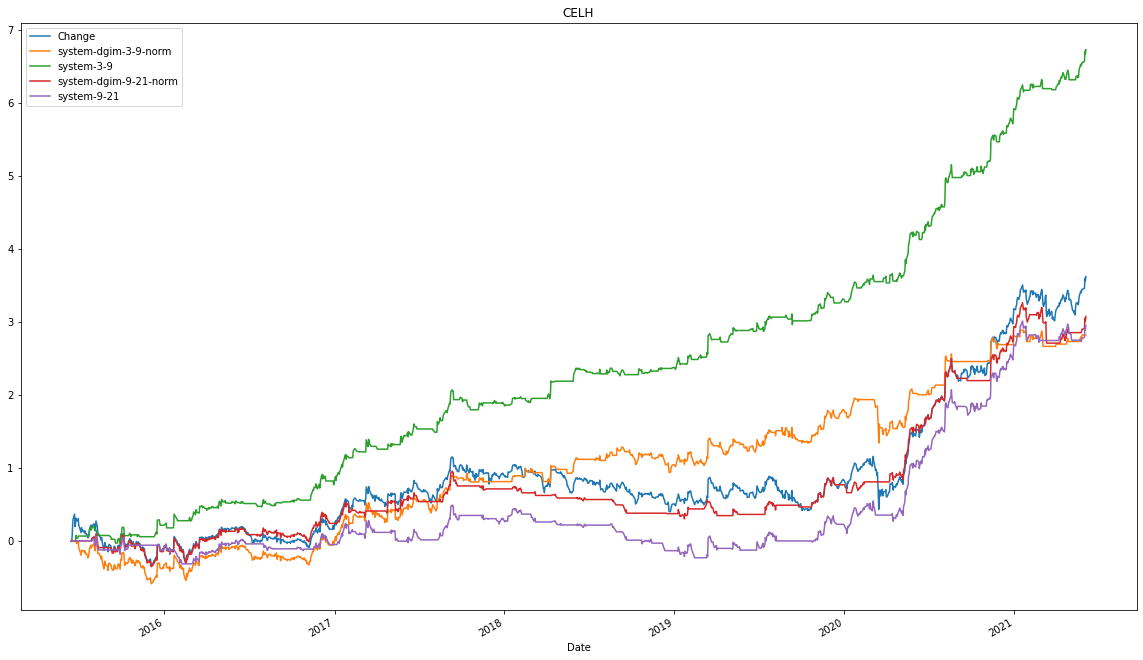

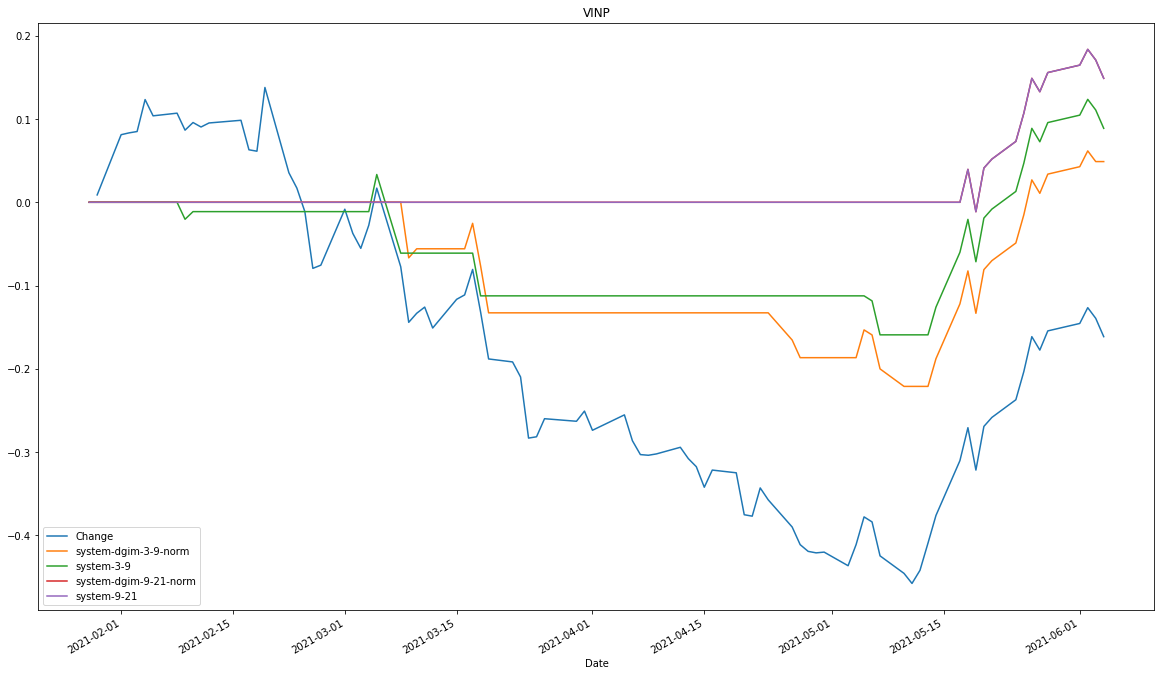

In [6]:
def printSystems(ticker):
    stocks[ticker][['Change','system-dgim-3-9-norm','system-3-9','system-dgim-9-21-norm','system-9-21']].cumsum().plot(title=ticker,figsize=(20,12))

threads = []

for ticker in tickers:
    ticker_thread = threading.Thread(target=printSystems, args=(ticker,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()

## View Accumulated Performance

Change  system-dgim-3-9-norm  system-3-9  \
2021-06-03  26.929141              40.24261   66.455029   
2021-06-04  27.061257              40.07767   66.562856   
2021-06-05  27.061257              40.07767   66.562856   
2021-06-06  27.061257              40.07767   66.562856   
2021-06-07  27.061257              40.07767   66.562856   

            system-dgim-9-21-norm  system-9-21  
2021-06-03              26.010838    24.159807  
2021-06-04              26.132405    24.340284  
2021-06-05              26.132405    24.340284  
2021-06-06              26.132405    24.340284  
2021-06-07              26.132405    24.340284

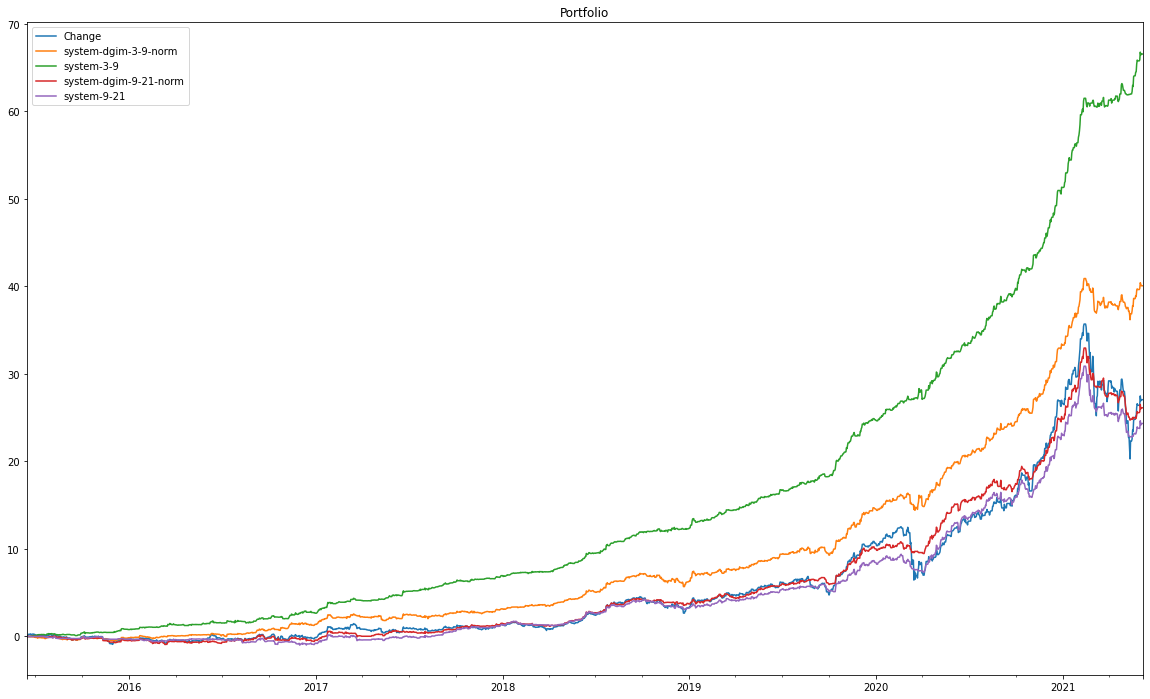

In [7]:
portfolio = 0
for ticker in tickers:
    idx = pd.date_range(date, pd.to_datetime('today'))
    portfolio += stocks[ticker].reindex(idx, fill_value=0)

portfolio[['Change','system-dgim-3-9-norm','system-3-9','system-dgim-9-21-norm','system-9-21']].cumsum().fillna(method ='pad').plot(title="Portfolio",figsize=(20,12))
portfolio[['Change','system-dgim-3-9-norm','system-3-9','system-dgim-9-21-norm','system-9-21']].cumsum().tail()

## Determine Mean Difference for MA and Normalized DGIM MA Performance against Baseline

In [8]:
analysis = []
for ticker in tickers:
    analysis.append({"gain-3-9": stocks[ticker]['system-3-9'].cumsum().tail(1)[0],
                     "gain-9-21": stocks[ticker]['system-9-21'].cumsum().tail(1)[0],
                     "gain-dgim-3-9-norm": stocks[ticker]['system-dgim-3-9-norm'].cumsum().tail(1)[0],
                     "gain-dgim-9-21-norm": stocks[ticker]['system-dgim-9-21-norm'].cumsum().tail(1)[0],
                     "change": stocks[ticker]['Change'].cumsum().tail(1)[0]})
analysisDf = pd.DataFrame(analysis)

meanDifference_3_9 = (analysisDf['gain-3-9'] - analysisDf['change']).mean()
meanDifference_9_21 = (analysisDf['gain-9-21'] - analysisDf['change']).mean()
meanDifference_dgim_3_9_norm = (analysisDf['gain-dgim-3-9-norm'] - analysisDf['change']).mean()
meanDifference_dgim_9_21_norm = (analysisDf['gain-dgim-9-21-norm'] - analysisDf['change']).mean()
print("meanDifference_3_9:",meanDifference_3_9)
print("meanDifference_9_21:", meanDifference_9_21)
print("meanDifference_dgim_3_9_norm:", meanDifference_dgim_3_9_norm)
print("meanDifference_dgim_9_21_norm:", meanDifference_dgim_9_21_norm)

meanDifference_3_9: 1.112158744833316
meanDifference_9_21: -0.09420045081726881
meanDifference_dgim_3_9_norm: 0.3554391665969449
meanDifference_dgim_9_21_norm: -0.0429969871747094
